<a href="https://colab.research.google.com/github/caalr11/FisicaComputacional1/blob/master/Actividad6/Actividad6_CarlosArias.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [93]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
from statsmodels.tsa.stattools import acf, pacf
import pandas.util.testing as tm
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

%matplotlib inline

In [94]:
url ="https://raw.githubusercontent.com/caalr11/FisicaComputacional1/master/Actividad1/data%20guaymas.txt"
my_cols = ['Fecha', 'Precip', 'Evap', 'Tmax', 'Tmin']
df_dist = pd.read_csv(url, names=my_cols, encoding='cp1251', sep='\s+', header=None, skiprows=19, skipfooter=1, engine='python')
df_ca0 = df_dist.copy()
str_Nulo = 'Nulo'
df_ca1 = df_ca0.replace(to_replace=str_Nulo, value='', regex=True)
cols_list = ['Precip', 'Evap', 'Tmax', 'Tmin']
for cols in cols_list:
  df_ca1[cols] = pd.to_numeric(df_ca1[cols], errors='coerce')
  df_ca2 = df_ca1.copy()
df_ca2['Fecha']=pd.to_datetime(df_ca2['Fecha'], dayfirst=True).copy()
df_ca2['Año'] = df_ca2['Fecha'].dt.year
df_ca2['Mes'] = df_ca2['Fecha'].dt.strftime('%b')
df_met = df_ca2.copy()
df_met_ts = df_met.copy()
df_met_ts = df_met_ts.set_index('Fecha')
df_met_ts.info()
df_67 = df_met_ts[(df_met_ts['Año'] >= 1967) & (df_met_ts['Año'] < 1990)]
df_90 = df_met_ts[(df_met_ts['Año'] >= 1990) & (df_met_ts['Año'] < 2016)]


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 17879 entries, 1967-02-01 to 2016-09-30
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Precip  17847 non-null  float64
 1   Evap    5731 non-null   float64
 2   Tmax    17823 non-null  float64
 3   Tmin    17828 non-null  float64
 4   Año     17879 non-null  int64  
 5   Mes     17879 non-null  object 
dtypes: float64(4), int64(1), object(1)
memory usage: 977.8+ KB


In [95]:
def test_stationarity(df_ts):
    rolmean = df_ts.rolling(window=365, center=True).mean()
    rolstd = df_ts.rolling(window=365, center=True).std() 
    plt.rcParams["figure.figsize"] = (12,6)
 
    plt.plot(df_ts, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std Deviation')
    plt.legend(loc='best')
    plt.title('Promedio Móvil y Desviación Estándar')
    plt.grid()
    plt.show()
    #Prueba Aumentada de Dickey-Fuller:
    print('Resultados de la Prueba de Dickey-Fuller:')
    dftest = adfuller(df_ts, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], 
                         index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [96]:
start, end = '2001-01', '2005-12'

ts_90 = df_90.loc[start:end].copy()
ts_90.head()

,Precip,Evap,Tmax,Tmin,Año,Mes
Fecha,,,,,,
2001-01-01,0.0,NaN,26.5,6.0,2001,Jan
2001-01-02,0.0,NaN,27.0,6.0,2001,Jan
2001-01-03,0.0,NaN,29.0,10.0,2001,Jan
2001-01-04,0.0,NaN,30.0,14.0,2001,Jan
2001-01-05,0.0,NaN,31.0,12.5,2001,Jan


In [97]:
ts_90['Tmax'].head()

Fecha
2001-01-01    26.5
2001-01-02    27.0
2001-01-03    29.0
2001-01-04    30.0
2001-01-05    31.0
Name: Tmax, dtype: float64

In [98]:
ts_test = ts_90['Tmax'].copy()

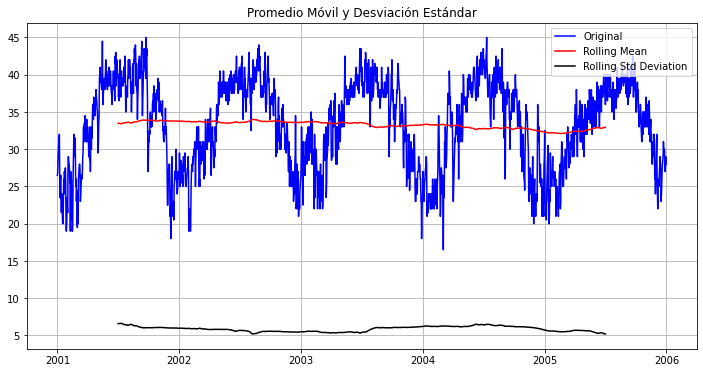

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                   -2.968895
p-value                           0.037903
#Lags Used                       14.000000
Number of Observations Used    1811.000000
Critical Value (1%)              -3.433966
Critical Value (5%)              -2.863137
Critical Value (10%)             -2.567620
dtype: float64


In [99]:
test_stationarity(ts_test)

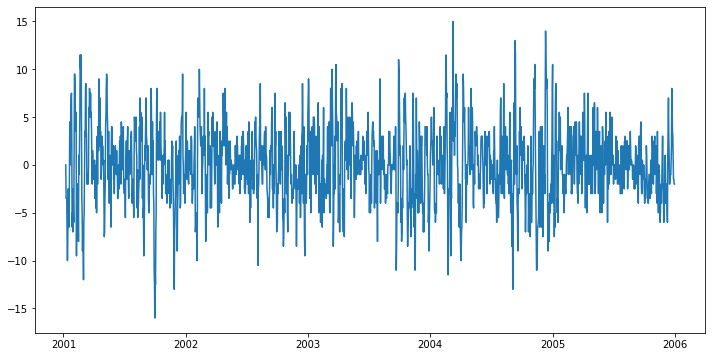

In [100]:
ts_test = ts_test - ts_test.shift(periods=7)
plt.plot(ts_test);

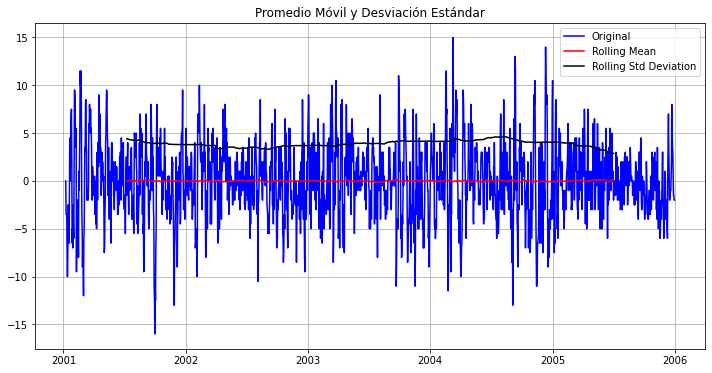

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -9.769134e+00
p-value                        7.214592e-17
#Lags Used                     2.100000e+01
Number of Observations Used    1.797000e+03
Critical Value (1%)           -3.433994e+00
Critical Value (5%)           -2.863150e+00
Critical Value (10%)          -2.567627e+00
dtype: float64


In [101]:
ts_test.dropna(inplace=True)
test_stationarity(ts_test)

In [102]:
len(ts_test)

1819

Vemos que nuestra grafica si obtuvo una p menor o igual a 5, empezo en 0.02 y ahorita con la modificacion llego a incluso mucho menor, pero vemos q la estacionalidad sigue estando.

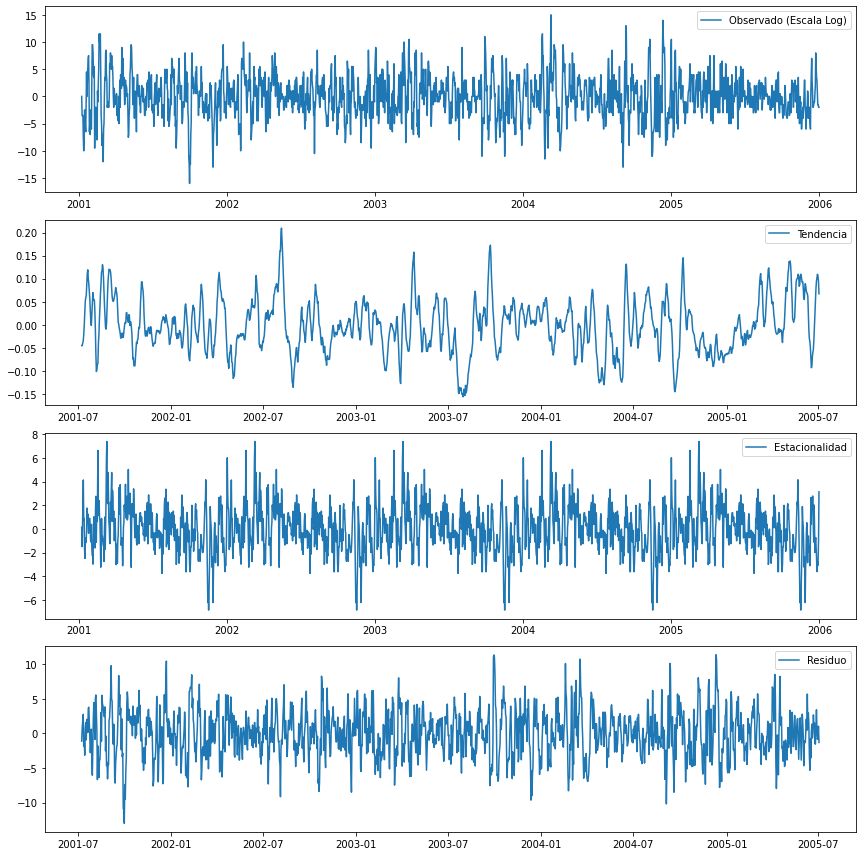

In [103]:
# Método de descomposición usando la biblioteca statsmodels.tsa
decomposition = sm.tsa.seasonal_decompose(ts_test.interpolate(), model='additive', freq=365)
# La función regresa 3 componentes: tendencia, estacionalidad y un residuo
trend = decomposition.trend
seasonal = decomposition.seasonal
residue = decomposition.resid
# Graficamos
plt.rcParams["figure.figsize"] = (12,12)
plt.subplot(411)
plt.plot(ts_test, label='Observado (Escala Log)')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Tendencia')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal, label='Estacionalidad')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residue, label='Residuo')
plt.legend(loc='best')
plt.tight_layout();

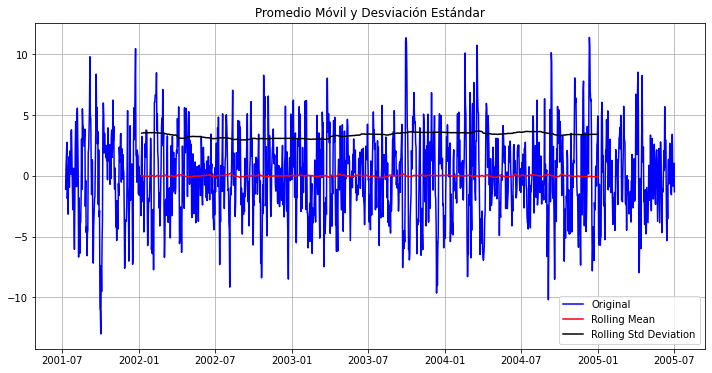

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -1.087846e+01
p-value                        1.313273e-19
#Lags Used                     2.200000e+01
Number of Observations Used    1.432000e+03
Critical Value (1%)           -3.434925e+00
Critical Value (5%)           -2.863560e+00
Critical Value (10%)          -2.567846e+00
dtype: float64


In [104]:
ts_test_decompose = residue 
ts_test_decompose.dropna(inplace=True)
test_stationarity(ts_test_decompose)


Esta serie es estacionaria porque la prueba da un valor de p < 0.05 (1.24x10^-22). Podemos afirmar que es una serie de tiempo estacionaria con mas de un 99% de confianza.


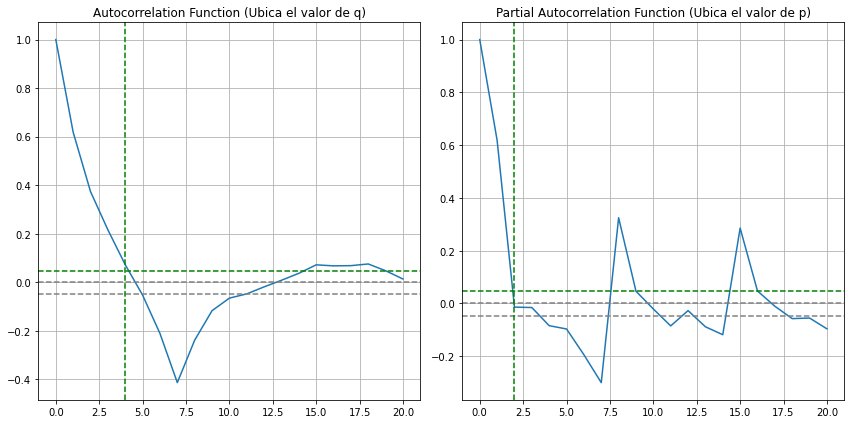

In [105]:
# ARIMA
lag_acf = acf(ts_test, nlags=20)
lag_pacf = pacf(ts_test, nlags=20, method = 'ols')
plt.rcParams["figure.figsize"] = (12,6)
# Gráfica de ACF (Autocorrelation Function)
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_test)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_test)), linestyle='--', color='green')
# lineas verticales
plt.axvline(x=4, linestyle='--', color='green')
plt.grid()
plt.title('Autocorrelation Function (Ubica el valor de q)')
# Gráfica de PACF (Partial Autocorrelation Function)
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_test)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_test)), linestyle='--', color='green')
# lineas verticales 
plt.axvline(x=2, linestyle='--', color='green')
plt.grid()
plt.title('Partial Autocorrelation Function (Ubica el valor de p)')
plt.tight_layout()

p=2 q=4

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                 D.Tmax   No. Observations:                 1818
Model:                 ARIMA(2, 1, 0)   Log Likelihood               -4748.154
Method:                       css-mle   S.D. of innovations              3.296
Date:                Sat, 20 Feb 2021   AIC                           9504.309
Time:                        06:03:19   BIC                           9526.331
Sample:                    01-09-2001   HQIC                          9512.434
                         - 12-31-2005                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.0006      0.057     -0.010      0.992      -0.112       0.111
ar.L1.D.Tmax    -0.2069      0.023     -8.924      0.000      -0.252      -0.161
ar.L2.D.Tmax    -0.1512      0.023     -6.52

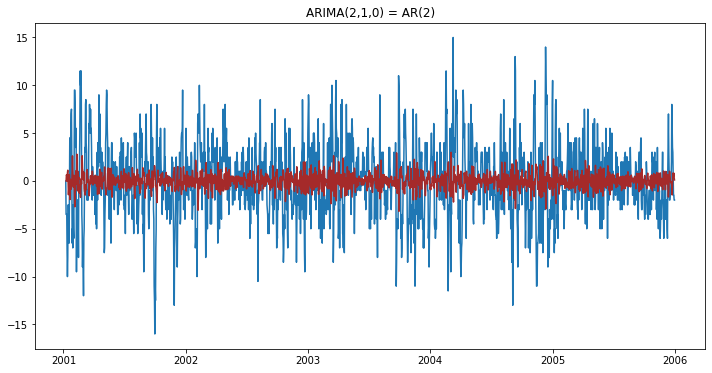

In [106]:
#p=2
model = ARIMA(ts_test, order=(2,1,0), missing='drop')
results_AR = model.fit(displ=-1)
plt.plot(ts_test)
plt.plot(results_AR.fittedvalues, color='brown')
plt.title('ARIMA(2,1,0) = AR(2)')
print(results_AR.summary())

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:492: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  'available', HessianInversionWarning)


                             ARIMA Model Results                              
Dep. Variable:                 D.Tmax   No. Observations:                 1818
Model:                 ARIMA(0, 1, 4)   Log Likelihood               -4615.893
Method:                       css-mle   S.D. of innovations              3.060
Date:                Sat, 20 Feb 2021   AIC                           9243.787
Time:                        06:03:26   BIC                           9276.820
Sample:                    01-09-2001   HQIC                          9255.975
                         - 12-31-2005                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.0001      0.000     -0.377      0.706      -0.001       0.000
ma.L1.D.Tmax    -0.3687      0.023    -15.713      0.000      -0.415      -0.323
ma.L2.D.Tmax    -0.2441      0.025     -9.84

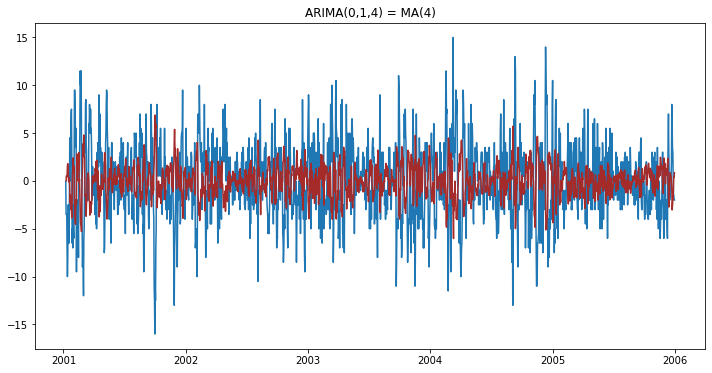

In [107]:
# q=4
model = ARIMA(ts_test, order=(0,1,4), missing='drop')
results_MA = model.fit(displ=-1)
plt.plot(ts_test)
plt.plot(results_MA.fittedvalues, color='brown')
plt.title('ARIMA(0,1,4) = MA(4)')
print(results_MA.summary())

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                 D.Tmax   No. Observations:                 1818
Model:                 ARIMA(2, 1, 4)   Log Likelihood               -4485.844
Method:                       css-mle   S.D. of innovations              2.840
Date:                Sat, 20 Feb 2021   AIC                           8987.689
Time:                        06:03:40   BIC                           9031.733
Sample:                    01-09-2001   HQIC                          9003.939
                         - 12-31-2005                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.0001      0.000     -0.449      0.653      -0.001       0.000
ar.L1.D.Tmax    -0.3619      0.025    -14.449      0.000      -0.411      -0.313
ar.L2.D.Tmax    -0.5247      0.021    -25.37

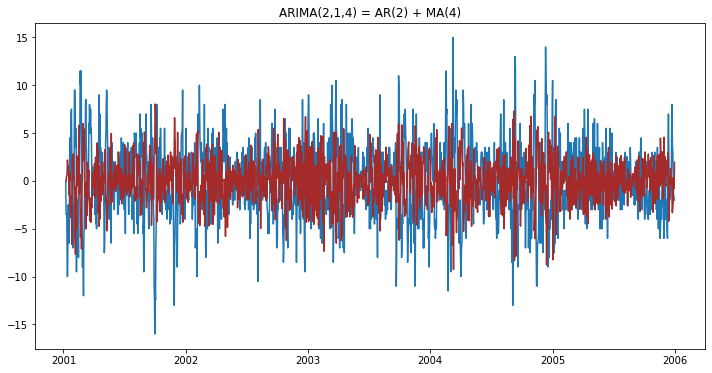

In [108]:
# ARIMA p y q juntos: (p,d,q) = (2,1,4) 
model = ARIMA(ts_test, order=(2,1,4), missing='drop')
results_ARIMA = model.fit(displ=-1)
plt.plot(ts_test)
plt.plot(results_ARIMA.fittedvalues, color='brown')
plt.title('ARIMA(2,1,4) = AR(2) + MA(4)')
print(results_ARIMA.summary())

El modelo 2,1,4 es el mas bajo.Podemos afirmar que es el mejor modelo que hay.[link text](https://)

In [109]:
#Seguiremos con TMin
print(ts_90['Tmin'].head())

Fecha
2001-01-01     6.0
2001-01-02     6.0
2001-01-03    10.0
2001-01-04    14.0
2001-01-05    12.5
Name: Tmin, dtype: float64


In [110]:
ts_test2 = ts_90['Tmin'].copy()

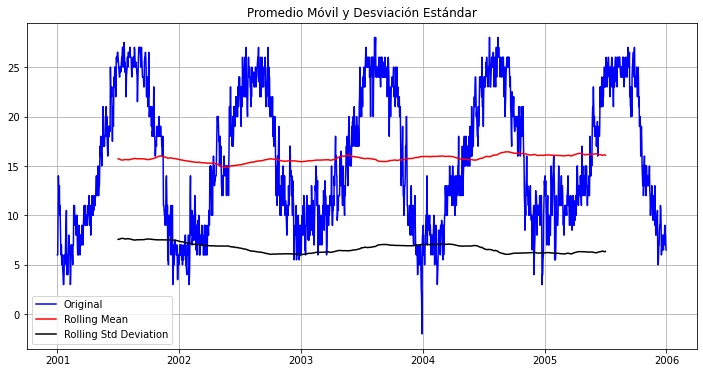

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                   -2.204519
p-value                           0.204609
#Lags Used                       12.000000
Number of Observations Used    1813.000000
Critical Value (1%)              -3.433962
Critical Value (5%)              -2.863136
Critical Value (10%)             -2.567619
dtype: float64


In [111]:
test_stationarity(ts_test2)

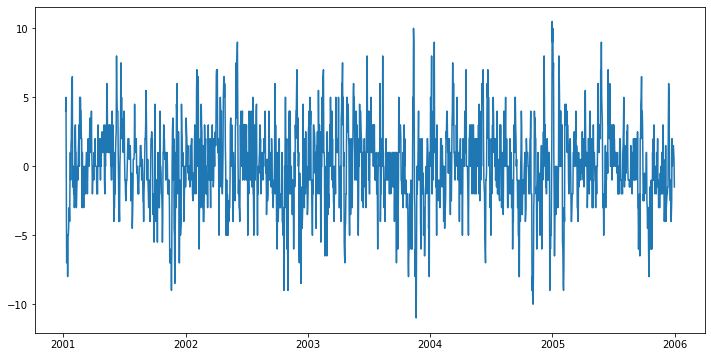

In [112]:
ts_test2_diff = ts_test2 - ts_test2.shift(periods=7)
plt.plot(ts_test2_diff);

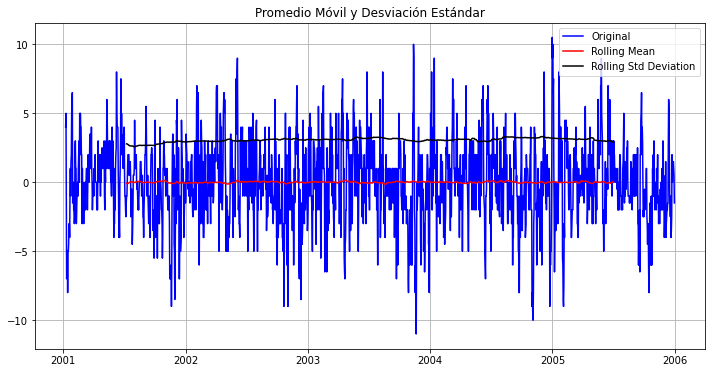

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -6.190351e+00
p-value                        6.144338e-08
#Lags Used                     2.200000e+01
Number of Observations Used    1.796000e+03
Critical Value (1%)           -3.433996e+00
Critical Value (5%)           -2.863151e+00
Critical Value (10%)          -2.567627e+00
dtype: float64


In [113]:
ts_test2_diff.dropna(inplace=True)
test_stationarity(ts_test2_diff)

Vemos que para el valor de p en la temperatura minima es menor a 5% (1.0^-26) por lo tanto podemos afirmar con un 99% de confianza que es estacionaria.

In [114]:
len(ts_test2_diff)

1819

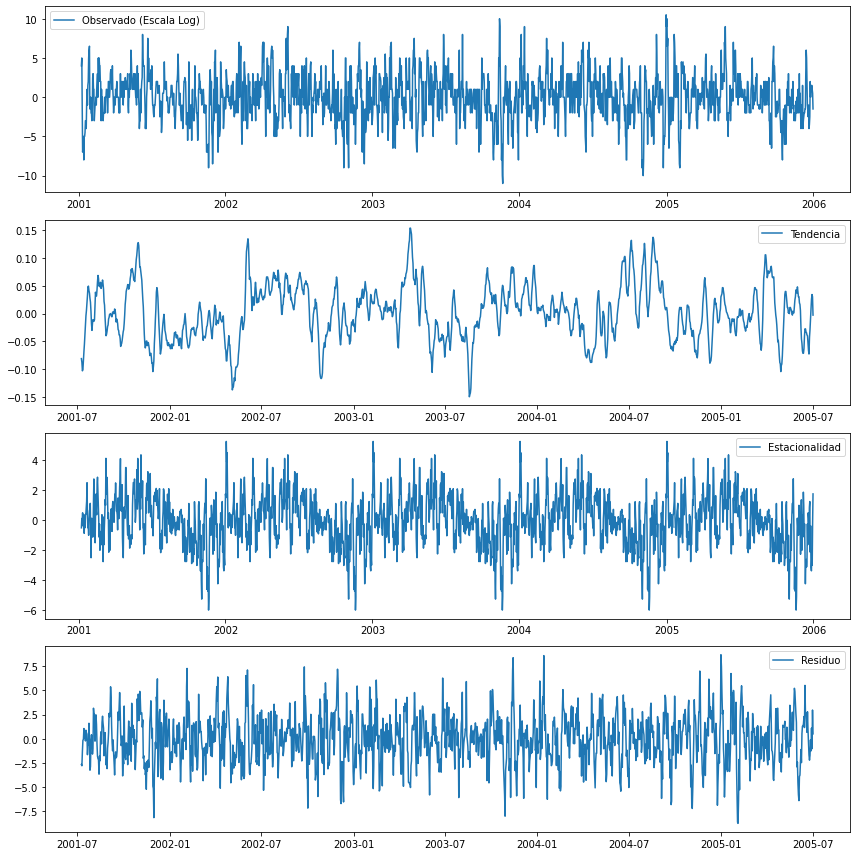

In [115]:
# Método de descomposición usando la biblioteca statsmodels.tsa

decomposition = sm.tsa.seasonal_decompose(ts_test2_diff.interpolate(), model='additive', freq=365)

# La función regresa 3 componentes: tendencia, estacionalidad y un residuo

trend = decomposition.trend
seasonal = decomposition.seasonal
residue = decomposition.resid

# Graficamos las componentes
plt.rcParams["figure.figsize"] = (12,12)
plt.subplot(411)
plt.plot(ts_test2_diff, label='Observado (Escala Log)')
plt.legend(loc='best')

plt.subplot(412)
plt.plot(trend, label='Tendencia')
plt.legend(loc='best')

plt.subplot(413)
plt.plot(seasonal, label='Estacionalidad')
plt.legend(loc='best')

plt.subplot(414)
plt.plot(residue, label='Residuo')
plt.legend(loc='best')

# Colocar gráficas lo más cercanas posibles
plt.tight_layout();

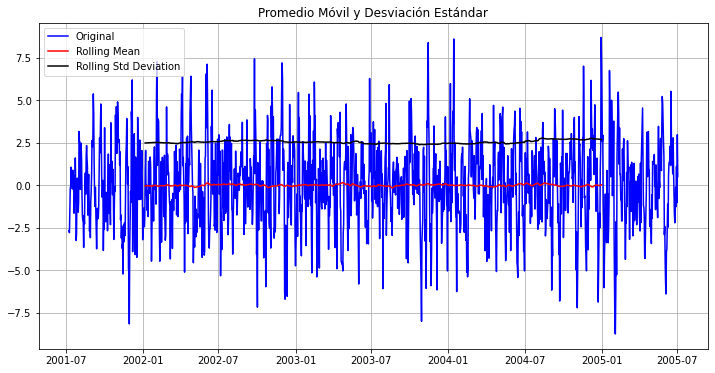

Resultados de la Prueba de Dickey-Fuller:
Test Statistic                -8.701427e+00
p-value                        3.800025e-14
#Lags Used                     2.200000e+01
Number of Observations Used    1.432000e+03
Critical Value (1%)           -3.434925e+00
Critical Value (5%)           -2.863560e+00
Critical Value (10%)          -2.567846e+00
dtype: float64


In [116]:
ts_test_decompose = residue 
ts_test_decompose.dropna(inplace=True)
test_stationarity(ts_test_decompose)

METODO ARIMA TMIN

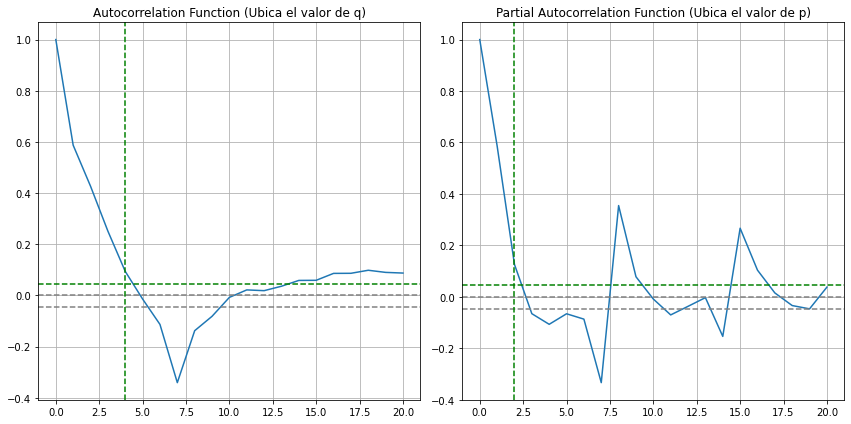

In [117]:
# Tmin
# Aplicamos ARIMA

lag_acf = acf(ts_test2_diff, nlags=20)
lag_pacf = pacf(ts_test2_diff, nlags=20, method = 'ols')

# Tamaño de las gráficas
plt.rcParams["figure.figsize"] = (12,6)

# Gráfica de ACF (Autocorrelation Function)
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_test2_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_test2_diff)), linestyle='--', color='green')
# Graficamos unas líneas verticales como referencias
#plt.axvline(x=5, linestyle='--', color='green')
plt.axvline(x=4, linestyle='--', color='green')
plt.grid()
plt.title('Autocorrelation Function (Ubica el valor de q)')

# Gráfica de PACF (Partial Autocorrelation Function)
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0, linestyle='--', color='gray')
plt.axhline(y=-1.96/np.sqrt(len(ts_test2_diff)), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(ts_test2_diff)), linestyle='--', color='green')
# Graficamos unas líneas verticales como referencias 
plt.axvline(x=2, linestyle='--', color='green')
plt.grid()
plt.title('Partial Autocorrelation Function (Ubica el valor de p)')

plt.tight_layout()

P=2 y Q=4

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                 D.Tmin   No. Observations:                 1818
Model:                 ARIMA(2, 1, 0)   Log Likelihood               -4297.476
Method:                       css-mle   S.D. of innovations              2.573
Date:                Sat, 20 Feb 2021   AIC                           8602.953
Time:                        06:04:49   BIC                           8624.975
Sample:                    01-09-2001   HQIC                          8611.078
                         - 12-31-2005                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.0027      0.043     -0.062      0.950      -0.086       0.081
ar.L1.D.Tmin    -0.3312      0.023    -14.170      0.000      -0.377      -0.285
ar.L2.D.Tmin    -0.0812      0.023     -3.47

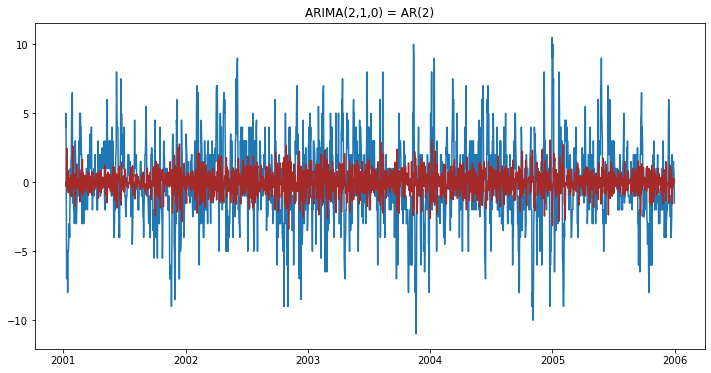

In [118]:
# Tmin
# Modelo AR(p): (p,d,q) = (2,1,0) 
model = ARIMA(ts_test2_diff, order=(2,1,0), missing='drop')
results2_AR = model.fit(displ=-1)
plt.plot(ts_test2_diff)
plt.plot(results2_AR.fittedvalues, color='brown')
plt.title('ARIMA(2,1,0) = AR(2)')
print(results2_AR.summary())

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                 D.Tmin   No. Observations:                 1818
Model:                 ARIMA(0, 1, 4)   Log Likelihood               -4169.316
Method:                       css-mle   S.D. of innovations              2.393
Date:                Sat, 20 Feb 2021   AIC                           8350.632
Time:                        06:04:54   BIC                           8383.665
Sample:                    01-09-2001   HQIC                          8362.820
                         - 12-31-2005                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.0002      0.000     -0.766      0.444      -0.001       0.000
ma.L1.D.Tmin    -0.4572      0.025    -18.619      0.000      -0.505      -0.409
ma.L2.D.Tmin    -0.0724      0.027     -2.66

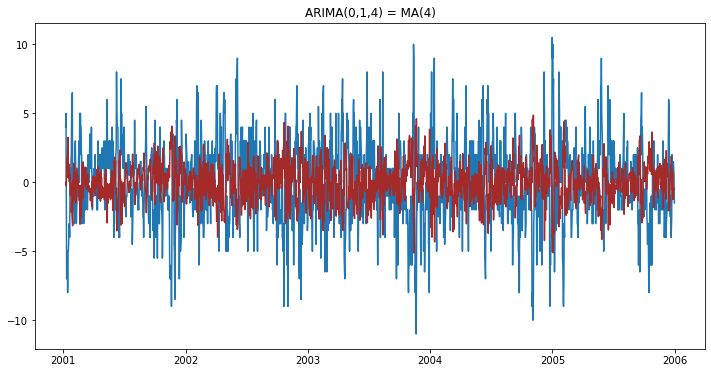

In [119]:
# Tmin
# Modelo MA(q): (p,d,q) = (0,1,4) 
model = ARIMA(ts_test2_diff, order=(0,1,4), missing='drop')
results2_MA = model.fit(displ=-1)
plt.plot(ts_test2_diff)
plt.plot(results2_MA.fittedvalues, color='brown')
plt.title('ARIMA(0,1,4) = MA(4)')
print(results2_MA.summary())

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                 D.Tmin   No. Observations:                 1818
Model:                 ARIMA(2, 1, 4)   Log Likelihood               -4052.114
Method:                       css-mle   S.D. of innovations              2.240
Date:                Sat, 20 Feb 2021   AIC                           8120.228
Time:                        06:05:09   BIC                           8164.271
Sample:                    01-09-2001   HQIC                          8136.478
                         - 12-31-2005                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.0003      0.002     -0.109      0.913      -0.005       0.004
ar.L1.D.Tmin    -0.4219      0.027    -15.545      0.000      -0.475      -0.369
ar.L2.D.Tmin    -0.4973      0.021    -23.51

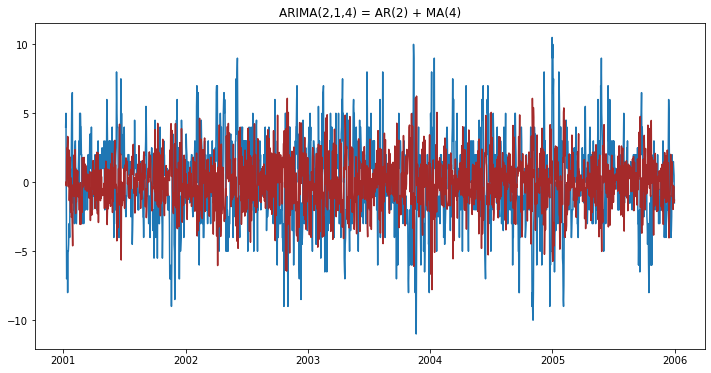

In [120]:
# Modelo ARIMA(p): (p,d,q) = (2,1,4) 
model = ARIMA(ts_test2_diff, order=(2,1,4), missing='drop')
results2_ARIMA = model.fit(displ=-1)
plt.plot(ts_test2_diff)
plt.plot(results2_ARIMA.fittedvalues, color='brown')
plt.title('ARIMA(2,1,4) = AR(2) + MA(4)')
print(results2_ARIMA.summary())

In [133]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)
predictions2_ARIMA_diff = pd.Series(results2_ARIMA.fittedvalues, copy=True)
print(predictions_ARIMA_diff)
print(predictions2_ARIMA_diff)

Fecha
2001-01-09   -0.000115
2001-01-10    0.467918
2001-01-11    0.494051
2001-01-12    0.820587
2001-01-13    2.178403
                ...   
2005-12-27   -2.271821
2005-12-28    0.291957
2005-12-29    0.071915
2005-12-30   -0.764621
2005-12-31    1.947527
Length: 1818, dtype: float64
Fecha
2001-01-09   -0.000260
2001-01-10   -0.259926
2001-01-11    1.608238
2001-01-12    2.483414
2001-01-13    2.402626
                ...   
2005-12-27   -1.964999
2005-12-28   -0.887963
2005-12-29   -0.292515
2005-12-30   -1.454543
2005-12-31   -1.311958
Length: 1818, dtype: float64


In [136]:
# Tmax
# Le sumamos las predicciones de ARIMA a la serie observada (ts_test)
predictions_ARIMA = pd.Series(ts_test, index = ts_test.index)
predictions_ARIMA = predictions_ARIMA.add(predictions_ARIMA_diff)
print(predictions_ARIMA.head())
print(predictions_ARIMA.tail())

# Tmin
# Le sumamos las predicciones de ARIMA a la serie observada (ts_test2_log)
predictions2_ARIMA = pd.Series(ts_test2, index = ts_test2.index)
predictions2_ARIMA = predictions2_ARIMA.add(predictions2_ARIMA_diff)
print(predictions2_ARIMA.head())
print(predictions2_ARIMA.tail())

Fecha
2001-01-08         NaN
2001-01-09   -3.500115
2001-01-10   -3.032082
2001-01-11   -3.005949
2001-01-12   -6.679413
dtype: float64
Fecha
2005-12-27   -1.271821
2005-12-28   -1.208043
2005-12-29   -1.428085
2005-12-30   -2.764621
2005-12-31   -0.052473
dtype: float64
Fecha
2001-01-01   NaN
2001-01-02   NaN
2001-01-03   NaN
2001-01-04   NaN
2001-01-05   NaN
dtype: float64
Fecha
2005-12-27    7.035001
2005-12-28    7.612037
2005-12-29    7.707485
2005-12-30    5.545457
2005-12-31    5.188042
dtype: float64


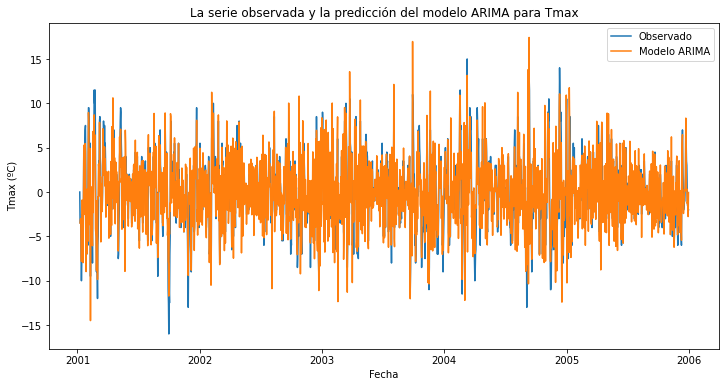

In [128]:
# Para Tmax, graficamos la serie original y las predicciones con ARIMA
# Tamaño de las gráficas
plt.rcParams["figure.figsize"] = (12,6)
# Gráficas
plt.plot(ts_test, label='Observado');
plt.plot(predictions_ARIMA, label='Modelo ARIMA');
# Ejes
plt.xlabel('Fecha')
plt.ylabel('Tmax (ºC)')
# Título y leyenda
plt.title('La serie observada y la predicción del modelo ARIMA para Tmax')
plt.legend(loc='best');

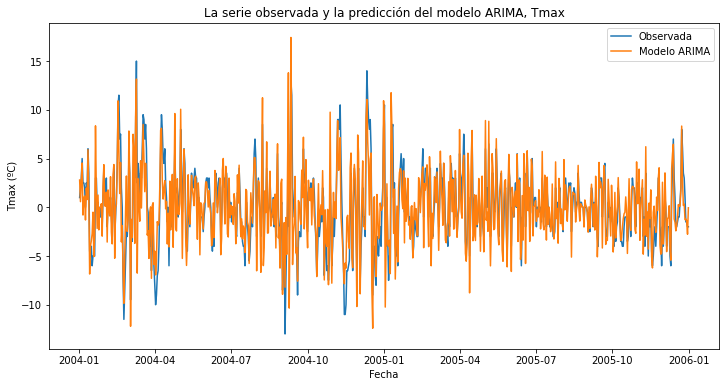

In [129]:
ts_test_last = ts_test.tail(730)
predictions_ARIMA_last = predictions_ARIMA.tail(730)

plt.plot(ts_test_last, label='Observada');
plt.plot(predictions_ARIMA_last, label='Modelo ARIMA');

plt.xlabel('Fecha')
plt.ylabel('Tmax (ºC)')
plt.title('La serie observada y la predicción del modelo ARIMA, Tmax')
plt.legend(loc='best');

GRAFICAS PARA TMIN

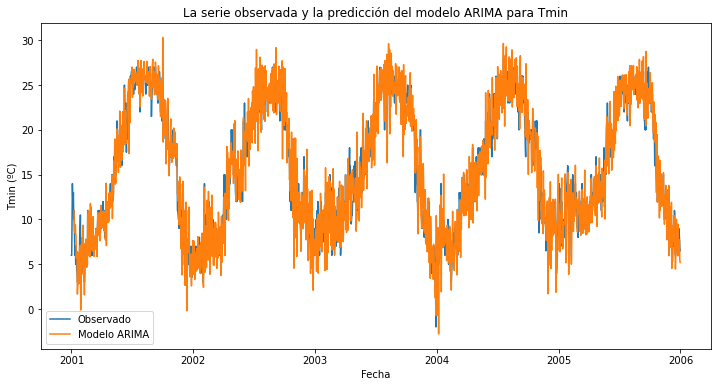

In [137]:
# Tmin
# Regresamos a la escala de Temperatura original 
plt.rcParams["figure.figsize"] = (12,6)
# Gráficas
plt.plot(ts_test2, label='Observado');
plt.plot(predictions2_ARIMA, label='Modelo ARIMA');
# Ejes
plt.xlabel('Fecha')
plt.ylabel('Tmin (ºC)')
# Título y leyenda
plt.title('La serie observada y la predicción del modelo ARIMA para Tmin')
plt.legend(loc='best');

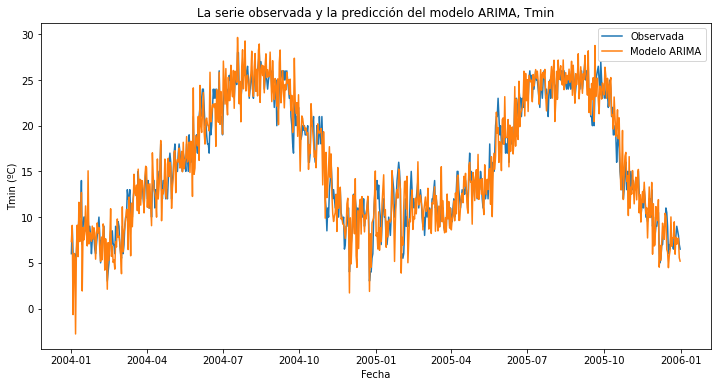

In [138]:
ts_test2_last = ts_test2.tail(730)
predictions2_ARIMA_last = predictions2_ARIMA.tail(730)

plt.plot(ts_test2_last, label='Observada');
plt.plot(predictions2_ARIMA_last, label='Modelo ARIMA');

plt.xlabel('Fecha')
plt.ylabel('Tmin (ºC)')
plt.title('La serie observada y la predicción del modelo ARIMA, Tmin')
plt.legend(loc='best');

ERROR DE LA RAIZ CUADRADA PROMEDIO RMSE PARA TMAX

In [139]:
RMSE = np.sqrt(np.mean((predictions_ARIMA - ts_test)**2))
print('RMSE:', RMSE)

RMSE: 2.3126839048427787


ERROR DE LA RAIZ CUADRADA PROMEDIO RMSE PARA TMIN

In [140]:
RMSE2 = np.sqrt(np.mean((predictions2_ARIMA - ts_test2)**2))
print('RMSE:', RMSE2)

RMSE: 1.89582856036995
